In [1]:
import os
import glob
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [3]:
# copy paste this code to the beginning of your script to set the plotting style for a one column figure

from matplotlib import pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "figure.constrained_layout.use": True
})

plt.rcParams["savefig.bbox"] = None
plt.rcParams["figure.figsize"] = (5.9,3)  # (width, height) in inches, change height but not width
plt.rcParams["figure.titlesize"] = 10 # this is only for plt.suptitle, i set it to be the same as the rest

plt.rcParams["axes.titlesize"] = 10 # control title size
plt.rcParams["axes.labelsize"] = 10 # control x and y axis labels
plt.rcParams["axes.labelpad"] = 4.0 # distance between axis label and axis numbers
plt.rcParams["xtick.labelsize"] = 10 # independent control of xlabel fontsize
plt.rcParams["ytick.labelsize"] = 10 # independent control of ylabel fontsize

plt.rcParams["legend.fontsize"] = 7.5 # control legend size, I set it to be slightly smaller than title/axes label
# plt.rcParams["legend.facecolor"] = (0.9, 0.9, 0.9) # legend background color
# plt.rcParams["legend.edgecolor"] = (0, 0, 0) # legend border line color
# plt.rcParams["legend.frameon"] = True # whether or not to draw a border around legend
# plt.rcParams["legend.framealpha"] = 0.1 # legend background transparency
plt.rcParams["legend.loc"] = "best" # default legend location
plt.rcParams["legend.handletextpad"] = 0.8  # Horizontal space between legend point and text (default 0.8)
plt.rcParams["legend.labelspacing"] = 0.6  # Vertical space between legend entries (default 0.5)
# plt.rcParams["legend.columnspacing"] = 2.0  # Space between columns in multi-column legends
# plt.rcParams["legend.borderpad"] = 1.0  # Space between legend content and the box
# plt.rcParams["legend.handlelength"] = 2.0  # Length of legend marker lines


# CHOOSE NICE COLOR FOR DARK MARKER EDGEWIDTH FROM "dodgerblue","mediumseagreen","indianred","mediumpurple","slateblue","darkorange","peru","goldenrod"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["lines.markersize"] = 6 #data point size
plt.rcParams["lines.markeredgewidth"] = 1.5 # width of the edge of the marker
plt.rcParams["lines.markeredgecolor"] = "black" # color of the edge of the marker
plt.rcParams["lines.markerfacecolor"] = "crimson" # color of the inside of the marker
plt.rcParams["lines.marker"] = "o" # marker type, see https://matplotlib.org/stable/api/markers_api.html for all options
plt.rcParams["lines.color"] = "black" # color of the line
# # CHOOSE NICE COLOR FOR DARK MARKER EDGEWIDTH FROM "dodgerblue","mediumseagreen","crimson","mediumpurple","slateblue","darkorange","peru","goldenrod"


plt.rcParams["grid.linestyle"] = "--"
plt.rcParams['axes.grid'] = True
# plt.rcParams["grid.linewidth"] = 0.7

# plt.rcParams["xtick.major.pad"] = 4.0 # distance between xticks dashes and xaxis numbers
# plt.rcParams["xtick.major.size"] = 3.0
# plt.rcParams["xtick.major.width"] = 0.7
# plt.rcParams["ytick.major.pad"] = 4.0 # distance between yticks dashes and yaxis numbers
# plt.rcParams["ytick.major.size"] = 3.0
# plt.rcParams["ytick.major.width"] = 0.7

# Data from 241206

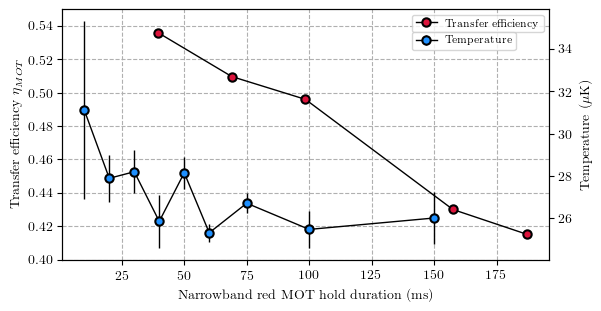

In [6]:
# file name and path
file_path = r"000017933-MeasureRedMOT.h5"
# Open the HDF5 file to extract the relevant datasets
with h5py.File(file_path, 'r') as h5file:
    # Extracting the axis and data for plotting
    x = h5file['datasets/ndscan.rid_17933.points.axis_0'][:] * 1000  # Convert to ms
    y = h5file['datasets/ndscan.rid_17933.points.channel_red_mot_normalised_bg_corrected_img_sum_horiz'][:]

# Data cleaning
# Remove the first point
x = x[1:]
y = y[1:]
# Remove the fourth point
x = np.delete(x, 3)
y = np.delete(y, 3)
# Remoev the ninth point
x = np.delete(x, 8)
y = np.delete(y, 8)
# Remove the fifteenth point
x = np.delete(x, 14)
y = np.delete(y, 14)

# Fit an exponential decay to the data
from scipy.optimize import curve_fit
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c
# Fit the data to the exponential decay function
popt, pcov = curve_fit(exp_decay, x[2:], y[2:]/10, p0=(0.2, 0.01, 0))
# Generate x values for the fitted curve
x_fit = np.linspace(min(x), max(x), 100)
# Generate y values for the fitted curve
y_fit = exp_decay(x_fit, *popt)
# Plot the original data and the fitted curve

fig, ax = plt.subplots()

ax.plot(x[:5], y[:5]/10, 'ko-', label='Transfer efficiency')
# ax.plot(x_fit, y_fit, '-', color='dodgerblue', label=r'Fit, $\tau$ = {:.0f}({:.0f}) ms'.format(1/popt[1],np.sqrt(pcov[1][1])/popt[1]**2))
ax.set_xlabel('Narrowband red MOT hold duration (ms)')
ax.set_ylabel(r'Transfer efficiency $\eta_{MOT}$')
ax.legend(loc='upper right')
ax.set_ylim(0.4, 0.55)

ax2 = ax.twinx()
temp_x = np.array([0.01,0.02,0.03,0.04,0.05,0.06,0.075,0.100,0.150])*1000
temp_y = [31.11,27.88,28.19,25.84,28.14,25.3,26.7,25.46,26.00]
temp_y_err = [4.23,1.11,1.01,1.26,0.76,0.42,0.47,0.89,1.22]
ax2.errorbar(temp_x, temp_y, yerr=temp_y_err, markerfacecolor='dodgerblue', color='black', label='Temperature')  # Large dots and connected points
ax2.grid(False)
ax2.set_ylabel(r'Temperature ($\mu$K)')
ax2.legend(bbox_to_anchor=(0.9425, 0.93))
# ax2.set_ylim(20, 60)

plt.savefig("250503 NbRedMOTHoldDurationTemperature.pdf", dpi=300)